# Symbolic Regression

This notebook contains the code used to run a Genetic Program, from scratch for creating a regressor.

The dataset used here is from the vineyard dataset


In [1]:
pip install bigtree pydot

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 1.4 MB/s eta 0:00:009.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#limit my CPU
import resource

# Set soft and hard limits for CPU time (in seconds)
soft_limit = 3600  # 1 hour
hard_limit = 7200  # 2 hours
resource.setrlimit(resource.RLIMIT_CPU, (soft_limit, hard_limit))

In [2]:
#importing necessary packages, pandas for reading in data, matplotlib for plotting the results
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import statistics
import builtins
from bigtree import tree_to_dot 
import time

## Reading in data

In [3]:
#reading in the dataset from the vineyard csv file
dataset = pd.read_csv("dataset_2178_vineyard.csv")
#dropping duplicates
dataset = dataset.drop_duplicates()
#print datasets before splitting
print(dataset.head())

#splitting data into training and testing sets
train_dataset= dataset.sample(frac=0.7, random_state=6)
test_dataset= dataset.drop(train_dataset.index)
#printing datasets to ensure it is correctly stored :)
print(train_dataset.head())
print(test_dataset.head())


   row_number  lugs_1989  lugs_1990  lugs_1991
0           1        1.0        5.0        9.5
1           2        3.0        8.0       17.5
2           3        3.0       11.0       18.0
3           4        3.0        9.0       20.0
4           5        5.0        9.5       20.5
    row_number  lugs_1989  lugs_1990  lugs_1991
51          52        0.0        2.5        2.5
41          42        1.5       10.0       15.0
39          40        2.0       10.0       16.0
23          24        4.0       13.0       22.0
7            8        4.5       10.0       21.0
    row_number  lugs_1989  lugs_1990  lugs_1991
1            2        3.0        8.0       17.5
4            5        5.0        9.5       20.5
9           10        5.0       10.0       26.0
10          11        6.0       11.0       20.0
11          12        5.0       10.0       23.0


# Initializing parameters

In [4]:
#initializing the training sets 
X_train = train_dataset[["lugs_1989","lugs_1990"]]
x1_train = train_dataset["lugs_1989"]
x2_train = train_dataset["lugs_1990"]
y_target_train = train_dataset["lugs_1991"]

#print heads to make sure it is initiated correctly
print(X_train.head())
print(x1_train.head())
print(x2_train.head())
print(y_target_train.head())

#initializing the testing sets
X_test= test_dataset[["lugs_1989","lugs_1990"]]
x1_test = test_dataset["lugs_1989"]
x2_test = test_dataset["lugs_1990"]
y_target_test = test_dataset["lugs_1991"]

#print heads to make sure it is initiated correctly
print(X_test.head())
print(x1_test.head())
print(x2_test.head())
print(y_target_test.head())

#i had to retrieve the indices due to the key7 error
index_train = X_train.index
index_test = X_test.index
print(index_train)
print(index_test)


    lugs_1989  lugs_1990
51        0.0        2.5
41        1.5       10.0
39        2.0       10.0
23        4.0       13.0
7         4.5       10.0
51    0.0
41    1.5
39    2.0
23    4.0
7     4.5
Name: lugs_1989, dtype: float64
51     2.5
41    10.0
39    10.0
23    13.0
7     10.0
Name: lugs_1990, dtype: float64
51     2.5
41    15.0
39    16.0
23    22.0
7     21.0
Name: lugs_1991, dtype: float64
    lugs_1989  lugs_1990
1         3.0        8.0
4         5.0        9.5
9         5.0       10.0
10        6.0       11.0
11        5.0       10.0
1     3.0
4     5.0
9     5.0
10    6.0
11    5.0
Name: lugs_1989, dtype: float64
1      8.0
4      9.5
9     10.0
10    11.0
11    10.0
Name: lugs_1990, dtype: float64
1     17.5
4     20.5
9     26.0
10    20.0
11    23.0
Name: lugs_1991, dtype: float64
Index([51, 41, 39, 23,  7,  0,  6, 34, 14, 32, 50, 24, 19,  3, 30, 29, 43, 31,
       36, 17, 21, 28, 40, 18, 22, 44, 46, 38,  5, 49, 27, 48, 12,  2,  8, 37],
      dtype='int64')
Index([1

## Initial Population Generation

The initial population will be generated using the growth method with initial tree depth of 2, with a limit of two trees created by the genetic operators

In [5]:
def growth_method(depth = 0):
    ##if the depth of the tree is reached put a terminal set
    if depth == max_depth:
        return random.choice(terminal)
    #root must be from the functional set
    elif depth == 0:
        node = random.choice(functional)
    else:
        #pick from a functional or a terminal set
        node = random.choice(functional + terminal)
    ##recursively grow tree if there is a root
        # If the node is a functional node, recursively grow the tree
    if node in functional:
        # Ensure operators like '-', '/', '**' have exactly 2 operands
        if node in ['-', '/', '**']:
            return [node, growth_method(depth + 1), growth_method(depth + 1)]
        # Allow operators like '+', '*' to have 2 or more operands
        elif node in ['+', '*']:
            num_operands = random.randint(2, 3)  # Adjust as needed
            return [node] + [growth_method(depth + 1) for _ in range(num_operands)]
        else:
            # Handle other operators (if any)
            return [node, growth_method(depth + 1), growth_method(depth + 1)]
    else :
        return node

def init_pop (population_size):
    pop = [growth_method() for _ in range(population_size)]
    return pop

def evaluate(expression, x1, x2, constant):
    # Base case: if the expression is a number or constant, return it
    if isinstance(expression, (int, float)):
        return expression
    # If the expression is 'x1', return the value of x1
    if expression == 'x1':
        return x1
    # If the expression is 'x2', return the value of x2
    if expression == 'x2':
        return x2
    # If the expression is 'constant', return the constant
    if expression == 'c':
        return constant
    
    # Recursive case: if the expression is a list, evaluate it
    if isinstance(expression, list):
        operator = expression[0]  # The first element is the operator
        operands = expression[1:]  # The rest are operands
        
        # Evaluate each operand recursively
        evaluated_operands = [evaluate(op, x1, x2, constant) for op in operands]
        
        # Perform the operation
        if operator == '+':
            return sum(evaluated_operands)
        elif operator == '*':
            result = 1
            for op in evaluated_operands:
                # Check for invalid values
                if not isinstance(op, (int, float)):
                    return 1  # Default value for invalid operands
                result *= op
            return result
        elif operator == '-':
            return evaluated_operands[0] - evaluated_operands[1]
        elif operator == '**':
            if len(evaluated_operands) != 2:
                return 1
            base, exponent = evaluated_operands[0], evaluated_operands[1]
            # Handle edge cases for exponentiation
            if base == 0 and exponent < 0:
                return 1  # Default value for 0 ** negative exponent
                try:
                    return base ** exponent
                except (OverflowError, ValueError):
                    return 1  # Default value for overflow or invalid operations
            else:
                return evaluated_operands[0] ** evaluated_operands[1]
        elif operator == '/':
            if evaluated_operands[1] == 0:
                return 1
            return evaluated_operands[0] / evaluated_operands[1]
        else:
            raise ValueError(f"Unknown operator: {operator}")
    
    # If the expression is not recognized, raise an error
    raise ValueError(f"Invalid expression: {expression}")


## Fitness Function

Calculating the fitness function 

In [33]:
#implementing regularization
def getting_leafs(equation):
    #to reduce complexity, check how long the tree is
    if isinstance(equation, list):
        return 1 + sum(getting_leafs(eq) for eq in equation)
    else:
        return 1

#fitness function
def fitness_fun(y_pred, y_target, index, tolerance, regulation, equation):
    n = len(y_target) #the number of values in the dataset
    summation = 0 #storing the  the summation
    i = 0
    for ind in index: #calculation of the summation
        diff = y_pred[i] - y_target[ind]
        absolute = abs(diff)
        summation = summation + absolute
        i+=1
    MAE = summation / n
    #calculating the hits criterion
    hits = 0
    for ypred, yhat in zip(y_pred,y_target):
        if abs(ypred - yhat) <= tolerance * abs(ypred):
            hits += 1
    hits_rate = hits / len(y_target)
    #calculating the regularization
    penalty = getting_leafs(equation)
    MAE = MAE 
    return MAE

## Selection Method:

The selection method used to find the the most fit parents is Tournament selection with a tournament score of 3

In [34]:
def tournament(population, fitness_scores, tournament_size, num_ind,):
    #selecting values of the tournament score
    combined = [[x, y] for x, y in zip(population, fitness_scores)]
    selected_parent= []
    for i in range(num_ind):
        selection = random.sample(combined , tournament_size)
        #select the best individual which is the smallest MSE
        if selection[i][1] > selection[i+1][1]:
            indx = combined.index(selection[i+1])
            selected_parent = selected_parent + population[indx]
        else:
            indx = combined.index(selection[i])
            selected_parent = selected_parent + population[indx]    
    return selected_parent

## Mutation and Cross-over Genetic Operators

With 60% of the population being reproduced using cross-over and 40% using mutation genetic operators

In [35]:
def crossover(parent1, parent2, probability):
    if random.uniform(0,1) < probability:
        #Choose a random integer that will represent a random point in the tree
        length = len(parent1) - 1
        point = random.randint(1, length)
        #Create offspring
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1,child2
    else:
        return parent1, parent2 #if crossover didn't occur

In [36]:
def mutation(parent, probability):
    if random.uniform(0,1) < probability:
        #Choose a random integer that will represent a random point in the tree
        length = len(parent1) - 1
        point = random.randint(1, length)
        #generate a random subtree
        if point < len(parent) and parent[point] in functional:
            subtree = random.choice(terminal)
        else:
            sub_tree = growth_method(depth=1)
        new_parent = parent[:point] + [sub_tree] + parent[point+1:]
        return new_parent
    else :
        return parent # if mutation didn't occur

# Calling functions

In [ ]:
#initializing the terminal and functional sets, with the initial tree depth of 2 and the limit of two trees made by the genetic operators
#seed = random.randint(0,15)
#print("Seed now is: ", seed)
random.seed(seed)
constant = 2
print(constant)
terminal = ["x1", "x2","c"]
functional = ["+","-","*","/"]

#calling the functions
population_size = 500
mutation_percentage = 0.15
crossover_percentage = 0.8
generations = 52
max_depth = 3
tolerance = 0.05
regulation = 0.05
reproduction_rate = 0.5

#having a first population
first_population = init_pop(population_size)

#to store the new population at every generation
curr_pop = first_population 
#collect all the fitness scores for each generation mainly for the histogram
gen_fitness_score=[]
#clean out the array for the new population
new_pop = []
for gen in range(generations):
    # to store the fitness score of each individual in the population for the selection process
    fit_score = []
    #to store the predicted Y value so i can calculate the fitness function of the generation
    y_pred = []
    #to combine the population with its fitness scores
    combined = []
    #Evaluate the fitness scores of each
    for i in range(len(curr_pop)):
        equation = curr_pop[i]
        #get predicted Y value for the training datasets
        temp_ypred = [] #temporary list for this equation
        for indx in index_train:
            y_predict = evaluate(equation,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant) 
            temp_ypred.append(y_predict)
        fitness_score = fitness_fun(temp_ypred, y_target_train, index_train, tolerance,regulation,equation)
        fit_score.append(fitness_score)
    #for reproduction/ elitism
    sorted = builtins.sorted #had to overwrite wasn't working on its own
    combined = [[x, y] for x, y in zip(curr_pop, fit_score)]
    #sorting
    sorted_pop= sorted(combined, key=lambda x: x[1])
    #getting the amount of individuals to keep
    num_individuals = int(reproduction_rate * len(curr_pop))
    best_individuals = []
    for i in range(num_individuals):
        best_individuals.append(sorted_pop[i][0])
    new_pop = best_individuals.copy()
    #troubleshooting Nan or infinite trees
    for f in range(len(fit_score)):
        if math.isnan(fit_score[f]) or math.isinf(fit_score[f]):
            #assigning them the worst fitness
            fit_score[f] = float(5000) 
    while len(new_pop) < len(curr_pop):
        #Selection using tournament selection
        parent1 = tournament(curr_pop, fit_score, tournament_size = 3 , num_ind = 1)
        parent2 = tournament(curr_pop, fit_score, tournament_size = 3, num_ind = 1)
        #getting fitness for parents
        y_p1 = []
        y_p2 = []
        for indx in index_train:
            y_pred_p1 = evaluate(parent1,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            y_pred_p2 = evaluate(parent2,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            y_p1.append(y_pred_p1)
            y_p2.append(y_pred_p2)
        parent1_fit = fitness_fun(y_p1, y_target_train, index_train, tolerance,regulation,equation)
        parent2_fit = fitness_fun(y_p2, y_target_train, index_train, tolerance,regulation,equation)
        #Create a crossover with the rate of 60%
        #child1 = crossover(parent1, parent2,crossover_percentage)
        children = crossover(parent1,parent2,crossover_percentage)
        child1 = children[0]
        child2 = children[1]
        #making the the crossover strict
        y_child1 = []
        y_child2 = []
        for indx in index_train:
            y_pred_c1 = evaluate(child1,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            y_pred_c2 = evaluate(child2,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            y_child1.append(y_pred_c1)
            y_child2.append(y_pred_c2)
        child1_fit = fitness_fun(y_child1, y_target_train, index_train, tolerance,regulation,equation)
        child2_fit = fitness_fun(y_child2, y_target_train, index_train, tolerance,regulation,equation)
        if child1_fit > parent1_fit and child1_fit > 0:#and child1_fit > parent2_fit:
            children = crossover(parent1,parent2,crossover_percentage)
            child1 = children[0]
            child2 = child2
        elif child2_fit > parent2_fit and child2_fit > 0: #and child2_fit > parent1_fit:
            children = crossover(parent1,parent2,crossover_percentage)
            child1 = child1
            child2 = children[1]
        else:
            child1 = child1
            child2 = child2
        #Create mutation with a mutation rate of 40%
        child1 = mutation(child1,mutation_percentage)
        child2 = mutation(child2, mutation_percentage)
        mut_c1_y = []
        mut_c2_y = []
        #creating a strict mutation
        for indx in index_train:
            y_pred_mc1 = evaluate(child1,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            y_pred_mc2 = evaluate(child2,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant)
            mut_c1_y.append(y_pred_mc1)
            mut_c2_y.append(y_pred_mc2)
        child1_mfit = fitness_fun(mut_c1_y, y_target_train, index_train, tolerance,regulation,equation)
        child2_mfit = fitness_fun(mut_c2_y, y_target_train, index_train, tolerance,regulation,equation)
        if child1_mfit > parent1_fit and child1_fit > 0:#and child1_fit > parent2_fit:
            children = crossover(parent1,parent2,crossover_percentage)
            child1 = children[0]
            child2 = child2
        elif child2_mfit > parent2_fit and child2_fit > 0: #and child2_fit > parent1_fit:
            children = crossover(parent1,parent2,crossover_percentage)
            child1 = child1
            child2 = children[1]
        else:
            child1 = child1
            child2 = child2
        new_pop.append(child1)
        new_pop.append(child2)
    aver= sum(fit_score)/len(fit_score)
    gen_fitness_score.append(aver)
    #replace population with new offspring
    curr_pop = new_pop[:population_size]
print("----------------------------------------------------------------------------")
print("-------------Best Predicted Equation----------------------------------------")
# trying to find the best from the last generation to check the best equation
final_pop_fits = []
for i in range(len(curr_pop)):
    equation = curr_pop[i]
    #get predicted Y value for the training datasets
    ypred = [] #temporary list for this equation
    for indx in index_train:
        y_predict = evaluate(equation,x1 = x1_train[indx],x2 = x2_train[indx],constant= constant) 
        ypred.append(y_predict)
    fitness_score = fitness_fun(ypred, y_target_train, index_train, tolerance,regulation,equation)
    final_pop_fits.append(fitness_score)
#getting equation from the last population
#checks for the smallest fitness score
best_fitted = min(final_pop_fits) 
#gets the index of that fitness score
best_index = fit_score.index(best_fitted)
#find the equation
best_equation = curr_pop[best_index]
print("MAE: ", best_fitted)
print(best_equation)

average = sum(final_pop_fits)/len(final_pop_fits)
#appending for the last generations fitness scores
gen_fitness_score.append(average)

Seed now is:  3
2


## Plotting graphs

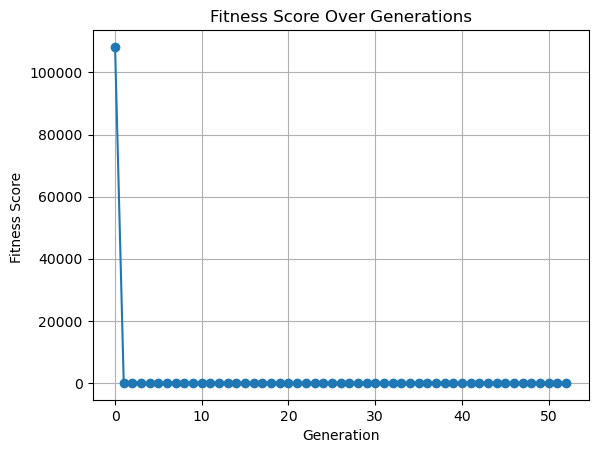

In [58]:
plt.plot(gen_fitness_score, marker='o')
plt.xlabel("Generation")
plt.ylabel("Fitness Score ")
plt.title("Fitness Score Over Generations")
plt.grid()
plt.show()

# Testing the given equation



In [62]:
##Testing the equation
test_fitness_score = []
ypred_test = []
for indx in index_test:
    y_pred_test = evaluate(best_equation,x1 = x1_test[indx],x2 = x2_test[indx],constant= constant) 
    ypred_test.append(y_predict)
average =statistics.mean(ypred_test)
deviation =statistics.stdev(ypred_test)
fitness_score_test = fitness_fun(ypred_test, y_target_test, index_test, tolerance, regulation,best_equation)

print("MAE: ",fitness_score_test)
print("Average: ",average)
print("Standard Dev:", deviation)

MAE:  3.59375
Average:  16.95
Standard Dev: 0.0
